In [8]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torchvision.transforms import Compose, ToTensor
from torchaudio.transforms import TimeMasking, FrequencyMasking
from torchvision.ops import SqueezeExcitation
import random
import math
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from torch.utils.data import random_split

In [71]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset

class AudioDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.dataset = []  # Store (file_path, label) pairs
        self._load_audio_files()

    def _load_audio_files(self):
        """Walk through the directory and collect (file_path, label) pairs."""
        for dirname, _, filenames in os.walk(self.data_dir):
            label = os.path.basename(dirname)  # Extract folder name as label

            # Ignore the root folder
            if label == os.path.basename(self.data_dir):
                continue  

            for filename in filenames:
                if filename.endswith(".wav"):  # Ensure it's an audio file
                    file_path = os.path.join(dirname, filename)
                    self.dataset.append((file_path, label))  # Store (path, label)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        file_path, label = self.dataset[idx]

        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)

        # Apply transformations
        if self.transform:
            waveform = self.transform(waveform)

        # Convert label to tensor (map string label to index)
        label_tensor = torch.tensor([ord(c) for c in label])  # ASCII encoding

        return waveform, label_tensor


In [37]:
import os
os.listdir('./Data')

['data_noiseless_final', '.DS_Store', 'MKA datasets']

In [42]:
# import re
# import torch

# for dirname, _, filenames in os.walk(path):
#     for filename in filenames:
#         print(f"Processing: {filename} in {dirname}")  # Debugging print

#         file_path = os.path.join(dirname, filename)

#         # Extract label from filename using regex (everything after "key-" and before "-")
#         match = re.search(r'key-([a-zA-Z0-9]+)-', filename)
#         if match:
#             label = match.group(1)  # Extracted full label
#             print(f"Extracted label: '{label}'")  # Debugging print
#         else:
#             raise ValueError(f"Could not extract label from filename: {filename}")

#         # Convert label to a tensor (you might want a mapping instead)
#         label_tensor = torch.tensor([ord(c) for c in label])  # Converts each char to ASCII
#         print(f"Label tensor: {label_tensor}")

#         # Load audio
#         waveform, sample_rate = torchaudio.load(file_path)


Processing: key-a-13.wav in Data/data_noiseless_final/
Extracted label: 'a'
Label tensor: tensor([97])
Processing: key-e-01.wav in Data/data_noiseless_final/
Extracted label: 'e'
Label tensor: tensor([101])
Processing: key-dot-02.wav in Data/data_noiseless_final/
Extracted label: 'dot'
Label tensor: tensor([100, 111, 116])
Processing: key-k-08.wav in Data/data_noiseless_final/
Extracted label: 'k'
Label tensor: tensor([107])
Processing: key-semicolon-11.wav in Data/data_noiseless_final/
Extracted label: 'semicolon'
Label tensor: tensor([115, 101, 109, 105,  99, 111, 108, 111, 110])
Processing: key-w-06.wav in Data/data_noiseless_final/
Extracted label: 'w'
Label tensor: tensor([119])
Processing: key-y-05.wav in Data/data_noiseless_final/
Extracted label: 'y'
Label tensor: tensor([121])
Processing: key-i-07.wav in Data/data_noiseless_final/
Extracted label: 'i'
Label tensor: tensor([105])
Processing: key-2-07.wav in Data/data_noiseless_final/
Extracted label: '2'
Label tensor: tensor([5

In [69]:
import os
print(os.path.exists('./Data/MKA datasets/All Dataset/Raw Data/'))  # Should print True

True


In [72]:
sample_rate = 44100
to_mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=64, hop_length=300, n_fft=1024+512, win_length=1024, f_min = 100, f_max=2500)
mel_spectrogram_to_numpy = lambda spectrogram: spectrogram.log2()[0,:,:].numpy()
transforms = Compose([to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor()])
dataset = AudioDataset('./Data/MKA datasets/All Dataset/Raw Data/', transforms)
len(dataset)

412

In [73]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Compute split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensure it sums to total_size

# Perform random split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [74]:
class TrainingDataset(Dataset):
    def __init__(self, base_dataset, transformations):
        super(TrainingDataset, self).__init__()
        self.base = base_dataset
        self.transformations = transformations

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        waveform, label = self.base[idx]
        return self.transformations(waveform), label

In [75]:
class TimeShifting():
    def __call__(self, samples):
        samples = samples.numpy()        
        shift = int(samples.shape[1] * 0.3)
        random_shift = random.randint(0, shift)
        data_roll = np.zeros_like(samples)
        data_roll[0] = np.roll(samples[0], random_shift)
        data_roll[1] = np.roll(samples[1], random_shift)
        return torch.tensor(data_roll)

In [81]:
aug_transforms = Compose([
    # TimeShifting(),
    to_mel_spectrogram, mel_spectrogram_to_numpy, ToTensor(),
    FrequencyMasking(7),
    TimeMasking(7),
    FrequencyMasking(7),
    TimeMasking(7)
])
train_set = TrainingDataset(train_dataset, aug_transforms)
val_set = TrainingDataset(val_dataset, transforms)
test_set = TrainingDataset(test_dataset, transforms)

In [82]:
len(train_set)

288

In [83]:
train_set[0]

(tensor([[[11.8605, 11.1556, 11.0574,  ..., 11.9076, 12.9960, 14.5396],
          [13.6031, 12.5243, 12.4261,  ..., 12.7974, 13.1678, 14.8996],
          [13.5826, 12.5354, 12.4372,  ..., 12.7974, 13.1678, 14.8996],
          ...,
          [ 8.2669,  7.0579,  6.9597,  ...,  9.3218, 11.7125, 10.3488],
          [12.0292, 11.5902, 11.4920,  ...,  7.9249, 10.0583, 10.8362],
          [13.6012, 12.3912, 12.2930,  ...,  9.3312, 12.8073, 13.7859]],
 
         [[11.1423,  8.5646,  8.4664,  ..., 14.0681, 15.2133, 14.4037],
          [12.7200,  7.8051,  7.7069,  ..., 14.7440, 15.3381, 13.8952],
          [12.7392,  7.7554,  7.6572,  ..., 14.7440, 15.3381, 13.8952],
          ...,
          [12.8657, 10.0857,  9.9875,  ..., 11.7922, 13.4327, 13.0803],
          [13.0297,  7.0303,  6.9321,  ..., 11.8606, 12.5423, 12.1124],
          [13.1414,  8.6264,  8.5282,  ..., 10.4343, 12.8003, 13.3824]],
 
         [[ 9.3785, 10.7675, 10.6693,  ..., 15.0409, 13.8389, 13.0712],
          [10.0255,  7.1573,

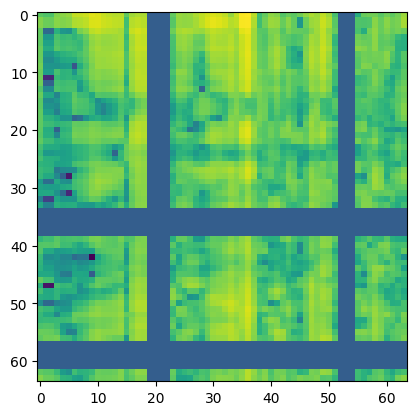

In [84]:
plt.imshow(train_set[0][0][0], cmap='viridis')

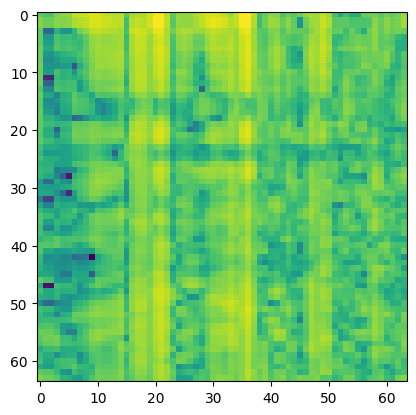

In [87]:
plt.imshow(transforms(train_dataset[0][0])[0], cmap='viridis')

In [88]:
class Stem(nn.Sequential):
    def __init__(self, out_channels):
        super().__init__(
            nn.Conv2d(1, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3)
        )

In [89]:
class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__()
        self.mb_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=3, padding=1, groups=in_channels * expansion_factor),
            nn.BatchNorm2d(in_channels * expansion_factor),
            nn.GELU(),
            SqueezeExcitation(in_channels * expansion_factor, in_channels, activation=nn.GELU),
            nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        return x + self.mb_conv(x)

In [90]:
class DownsamplingMBConv(MBConv):
    def __init__(self, in_channels, out_channels, expansion_factor=4):
        super().__init__(in_channels, out_channels, expansion_factor=4)
        self.mb_conv[1] = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, stride = 2)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.mb_conv(x)

In [91]:
class RelativeAttention2d(nn.Module):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__()
        heads = out_channels // head_size
        self.heads = heads
        self.head_size = head_size
        self.image_size = image_size
        self.head_dim = heads * head_size
        self.attend = nn.Softmax(dim=-2) # Taken from My_CoAtNet
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.to_q = nn.Linear(in_channels, self.head_dim)
        self.to_k = nn.Linear(in_channels, self.head_dim)
        self.to_v = nn.Linear(in_channels, self.head_dim)
        self.to_output = nn.Sequential(
            nn.Linear(self.head_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(in_channels)
        
        self.relative_bias = nn.Parameter(torch.randn(heads, (2 * image_size - 1) * (2 * image_size - 1)))
        self.register_buffer("relative_indices", self.get_indices(image_size, image_size)) # Taken from My_CoAtNet
        self.precomputed_relative_bias = None
    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def get_relative_biases(self):
        # Relative bias caching mentioned in CoAtNet: Marrying Convolution and Attention for All Data Sizes
        if not self.training:
            return self.precomputed_relative_bias
        # Taken from od My_CoAtNet
        indices = self.relative_indices.expand(self.heads, -1)
        rel_pos_enc = self.relative_bias.gather(-1, indices)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (self.image_size * self.image_size, self.image_size * self.image_size))
        return rel_pos_enc
    
    def reshape_for_linear(self, x):
        b, _, _, _ = x.shape
        return x.reshape(b, self.image_size * self.image_size, self.in_channels)
    
    def attention_score(self, x):
        b, _, h, _ = x.shape
        q = self.to_q(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        k = self.to_k(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        dots = torch.matmul(k.transpose(-1, -2), q) / math.sqrt(self.head_dim)
        relative_biases_indexed = self.get_relative_biases()
        return self.attend(dots + relative_biases_indexed)
    
    def relative_attention(self, x):
        b, _, _, _ = x.shape
        v = self.to_v(self.reshape_for_linear(x)).view(b, self.heads, self.head_size, -1) # Taken from My_CoAtNet
        out = torch.matmul(v, self.attention_score(x)) # I figured this out after debugging (Still the same as My_CoAtNet)
        out = out.view(b, self.image_size, self.image_size, -1)
        return self.to_output(out).view(b, self.out_channels, self.image_size, self.image_size)
        
    def forward(self, x):
        return x + self.relative_attention(self.norm(x))
    
    def train(self, training):
        if not training:
            self.precomputed_relative_bias = self.get_relative_biases()
        super().train(training)
        
    # Taken from My_CoAtNet
    @staticmethod
    def get_indices(h, w):
        y = torch.arange(h, dtype=torch.long)
        x = torch.arange(w, dtype=torch.long)
        
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x)
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1
        indices = indices.flatten()
        
        return indices

In [92]:
class DownsamplingRelativeAttention2d(RelativeAttention2d):
    def __init__(self, in_channels, out_channels, image_size, heads=8, head_size=32):
        super().__init__(in_channels, out_channels, image_size, heads=8, head_size=32)
        self.channel_projection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.normalization = nn.LayerNorm(in_channels)


    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
        
    def forward(self, x):
        return self.channel_projection(self.pool(x)) + self.relative_attention(self.pool(self.norm(x)))

In [93]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, out_channels, expansion_factor=4):
        super().__init__()
        hidden_dim = out_channels * expansion_factor
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_channels),
            nn.Dropout(0.3)
        )
        self.normalization = nn.LayerNorm(out_channels)
        self.out_channels = out_channels

    
    def norm(self, x):
        x = x.transpose(1, -1) # Taken from My_CoAtNet
        x = self.normalization(x)
        x = x.transpose(-1, 1) # Taken from My_CoAtNet
        return x
    
    def forward(self, x):
        old_shape = x.shape
        batch_size = old_shape[0]
        return x + torch.reshape(self.ffn(torch.reshape(self.norm(x), (batch_size, -1, self.out_channels))), old_shape)
    

In [94]:
class DownsampleTransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = DownsamplingRelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [95]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, image_size):
        attention = RelativeAttention2d(in_channels, out_channels, image_size)
        ffn = FeedForwardNetwork(out_channels)
        super().__init__(
            attention,
            ffn
        )

In [96]:
class Head(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_classes)
        self.in_channels = in_channels
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool(x)
        x = torch.reshape(x, (batch_size, -1, self.in_channels))
        return torch.squeeze(self.fc(x))
    

In [97]:
class MyCoAtNet(nn.Sequential):
    def __init__(self, nums_blocks, layer_out_channels, num_classes=26):
        s0 = nn.Sequential(Stem(layer_out_channels[0]))
        
        s1 = [DownsamplingMBConv(layer_out_channels[0], layer_out_channels[1])]
        for i in range(nums_blocks[1] - 1):
            s1.append(MBConv(layer_out_channels[1], layer_out_channels[1]))
        s1 = nn.Sequential(*s1)
        
        s2 = [DownsamplingMBConv(layer_out_channels[1], layer_out_channels[2])]
        for i in range(nums_blocks[2] - 1):
            s2.append(MBConv(layer_out_channels[2], layer_out_channels[2]))
        s2 = nn.Sequential(*s2)
        
        s3 = [DownsampleTransformerBlock(layer_out_channels[2], layer_out_channels[3], 64 // 16)]
        for i in range(nums_blocks[3] - 1):
            s3.append(TransformerBlock(layer_out_channels[3], layer_out_channels[3], 64 // 16))
        s3 = nn.Sequential(*s3)
        
        s4 = [DownsampleTransformerBlock(layer_out_channels[3], layer_out_channels[4], 64 // 32)]
        for i in range(nums_blocks[4] - 1):
            s4.append(TransformerBlock(layer_out_channels[4], layer_out_channels[4], 64 // 32))
        s4 = nn.Sequential(*s4)
        
        head = Head(layer_out_channels[4], num_classes)
        
        super().__init__(
            s0,
            s1,
            s2,
            s3,
            s4,
            head
        )
            

In [98]:
nums_blocks = [2, 2, 3, 5, 2]           # L
channels = [64, 96, 192, 384, 768]      # D
model = MyCoAtNet(nums_blocks, channels)

/home2/faculty/jprzybytniowska/.pyenv/versions/3.9.6/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [99]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [101]:
!pip install torchsummary

In [102]:
model.apply(init_linear)
model.to(device);
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))
from torchinfo import summary
from torchsummary import summary
summary(model, input_size=(1, 64, 64))

Number of parameters: 24,025,606
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 30, 30]          36,928
         MaxPool2d-5           [-1, 64, 15, 15]               0
            Conv2d-6           [-1, 96, 15, 15]           6,144
       BatchNorm2d-7           [-1, 64, 30, 30]             128
            Conv2d-8          [-1, 256, 15, 15]          16,640
       BatchNorm2d-9          [-1, 256, 15, 15]             512
             GELU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]           2,560
      BatchNorm2d-12          [-1, 256, 15, 15]             512
             GELU-13          [-1, 256, 15, 15]               0
Adapti

In [124]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    inputs, labels = zip(*batch)

    # Pad the inputs to have the same length
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)  # Adjust padding_value as needed

    # If labels are sequences, pad them (if needed)
    if isinstance(labels[0], torch.Tensor):  # Check if labels are tensors (sequences)
        labels = pad_sequence(labels, batch_first=True, padding_value=0)  # Adjust padding_value as needed
    else:
        # Stack single-label entries (if labels are scalar or single-value tensors)
        labels = torch.stack(labels)

    return inputs, labels

In [125]:
train_dataloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    num_workers=2,
    shuffle=True,
    collate_fn=collate_fn  # Use the custom function
)

val_dataloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=16,
    num_workers=2,
    shuffle=True,
    collate_fn=collate_fn
)
test_dataloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    num_workers=2,
    shuffle=True,
    collate_fn=collate_fn
)

In [128]:
for inputs, labels in train_dataloader:
    print(f"Batch size: {inputs.size()}")  # Shape of the inputs (should show [batch_size, max_time_steps, n_mels])
    break

Batch size: torch.Size([16, 14, 64, 64])


In [129]:
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d)
    
    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [130]:
cost = torch.nn.CrossEntropyLoss()

learning_rate = 5e-4
weight_decay = 0.1
num_epochs = 110
min_learning_rate = 1e-6

param_dict = {pn: p for pn, p in model.named_parameters()}
parameters_decay, parameters_no_decay = separate_parameters(model)
parameter_groups = [
    {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
    {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
]
optimizer = torch.optim.AdamW(parameter_groups, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=min_learning_rate / learning_rate, total_iters=num_epochs)

In [131]:
def plot_results(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.title("Loss")
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.legend(["Training loss", "Validation loss"], loc =  "best")
    plt.subplot(1,2,2)
    plt.title("Accuracy")
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.legend(["Training accuracy", "Validation accuracy"], loc =  "best")
    plt.show()

In [132]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [133]:
best_model_path = "/kaggle/working/CoAtNet-1-Best.pkl"
model_path = "/kaggle/working/CoAtNet-1.pkl"
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = torch.squeeze(labels).to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = cost(outputs, torch.squeeze(labels))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss.backward()
            optimizer.step()
        
        previous_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        next_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {correct/total}", "Correct:", correct, "Total:", total, f"LR: {previous_lr} -> {next_lr}")
        train_losses.append(loss.item())
        train_accuracies.append(correct/total)

        # Validation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = torch.squeeze(labels).to(device)
                outputs = model(inputs)
                
                loss = cost(outputs, torch.squeeze(labels))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f"Validation Accuracy: {correct/total}", f"Validation loss: {loss}", "Correct:", correct, "Total:", total)
            val_losses.append(loss.item())
            val_accuracies.append(correct/total)
        
        if epoch != 0 and (epoch % 50 == 49):
            plot_results(train_losses, train_accuracies, val_losses, val_accuracies)
        if epoch > 2 and val_accuracies[-1] > max(val_accuracies[:-1]):
            save_model(model, best_model_path)

RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[16, 13, 64, 64] to have 1 channels, but got 13 channels instead